## Env

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |


In [2]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv')
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv')

display(train.head())
display(test.head())

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,134764,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,9854,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,94365,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,110641,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,100159,42.9,58.7,14.5,A,4,23,PL233,232,1564


,Id,X1,X2,X3,X4,X5,X6,X7,X8
0,0,158065,80.6,104.8,11.0,A,29,23,PL234
1,1,65927,141.8,34.2,17.5,A,2,91,PL911
2,2,117029,77.2,103.3,17.0,A,10,97,PL973
3,3,50866,95.5,131.0,18.0,A,2,23,PL234
4,4,151900,91.7,36.1,19.0,AH32,1,27,PL271


## Preprocessing

In [4]:
# train = train.rename(columns = {
#     'X1' : '작업번호',
#     'X2' : '마킹길이',
#     'X3' : '절단길이',
#     'X4' : '철판두께',
#     'X5' : '철판재질',
#     'X6' : '절단갯수',
#     'X7' : '작업장',
#     'X8' : '작업자',
#     'Y1' : '마킹시간',
#     'Y2' : '절단시간'
# })

# test = test.rename(columns = {
#     'X1' : '작업번호',
#     'X2' : '마킹길이',
#     'X3' : '절단길이',
#     'X4' : '철판두께',
#     'X5' : '철판재질',
#     'X6' : '절단갯수',
#     'X7' : '작업장',
#     'X8' : '작업자'
# })

In [5]:
categorical_features = ['X5', 'X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 2/2 [00:00<00:00, 28.55it/s]


In [6]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X1      121754 non-null  int64  
 1   X2      121754 non-null  float64
 2   X3      121754 non-null  float64
 3   X4      121754 non-null  float64
 4   X5      121754 non-null  int32  
 5   X6      121754 non-null  int64  
 6   X7      121754 non-null  int64  
 7   X8      121754 non-null  int32  
 8   Y1      121754 non-null  int64  
 9   Y2      121754 non-null  int64  
dtypes: float64(3), int32(2), int64(5)
memory usage: 8.4 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40571 entries, 0 to 40570
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      40571 non-null  int64  
 1   X1      40571 non-null  int64  
 2   X2      40571 non-null  float64
 3   X3      40571 non-null  float64
 4   X4      40571 non-null  float64
 5   X5      40571 non-null  int32  
 6   X6      40571 non-null  int64  
 7   X7      40571 non-null  int64  
 8   X8      40571 non-null  int32  
dtypes: float64(3), int32(2), int64(4)
memory usage: 2.5 MB


None

In [7]:
train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,134764,56.3,67.5,22.5,10,4,97,24,467,2241
1,9854,115.0,67.0,13.0,10,2,27,17,1058,1163
2,94365,59.2,44.6,18.0,11,1,14,0,270,1094
3,110641,52.1,97.4,15.0,3,17,24,11,391,2604
4,100159,42.9,58.7,14.5,3,4,23,8,232,1564


In [8]:
display(train)

test.drop(columns = ['Id'], inplace = True)
display(test)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,134764,56.3,67.5,22.5,10,4,97,24,467,2241
1,9854,115.0,67.0,13.0,10,2,27,17,1058,1163
2,94365,59.2,44.6,18.0,11,1,14,0,270,1094
3,110641,52.1,97.4,15.0,3,17,24,11,391,2604
4,100159,42.9,58.7,14.5,3,4,23,8,232,1564
...,...,...,...,...,...,...,...,...,...,...
121749,147050,98.4,89.5,10.0,8,8,21,26,906,1226
121750,151590,48.0,51.0,23.0,54,1,23,7,175,1540
121751,152421,42.5,30.2,34.0,40,5,27,18,376,1492
121752,161172,22.1,15.3,36.0,15,8,97,24,85,723


,X1,X2,X3,X4,X5,X6,X7,X8
0,158065,80.6,104.8,11.0,4,29,23,10
1,65927,141.8,34.2,17.5,4,2,91,21
2,117029,77.2,103.3,17.0,4,10,97,25
3,50866,95.5,131.0,18.0,4,2,23,10
4,151900,91.7,36.1,19.0,11,1,27,18
...,...,...,...,...,...,...,...,...
40566,112358,27.0,13.0,19.0,11,21,25,13
40567,150907,44.2,41.3,19.5,11,2,14,2
40568,57481,54.9,70.5,15.0,4,10,23,9
40569,48467,44.1,43.2,16.0,4,1,27,19


In [9]:
display(train.describe())
display(test.describe())

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,81048.692675,77.608615,73.875636,17.444897,9.386312,13.630049,43.921152,14.412389,8.971671e+02,2193.206638
std,46870.157635,48.006125,53.267359,4.498316,11.876375,20.751914,32.509414,8.233702,4.604704e+04,2299.585390
min,1.000000,3.200000,1.800000,6.000000,0.000000,1.000000,14.000000,0.000000,0.000000e+00,0.000000
25%,40428.250000,45.200000,40.900000,14.500000,3.000000,1.000000,22.000000,7.000000,2.380000e+02,1064.000000
50%,81043.500000,68.100000,52.800000,17.000000,10.000000,4.000000,25.000000,16.000000,3.790000e+02,1593.000000
75%,121554.750000,98.300000,93.000000,20.000000,10.000000,18.000000,91.000000,21.000000,5.480000e+02,2778.000000
max,162341.000000,524.400000,621.300000,40.000000,78.000000,416.000000,97.000000,28.000000,6.157364e+06,348262.000000


,X1,X2,X3,X4,X5,X6,X7,X8
count,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000
mean,81536.254122,78.408661,73.741996,17.488975,10.371004,13.451209,43.929161,15.403071
std,46845.236185,48.351212,53.069122,4.505772,11.843162,20.591742,32.503838,8.199274
min,4.000000,3.700000,1.100000,6.000000,1.000000,1.000000,14.000000,1.000000
25%,41100.500000,45.700000,41.000000,14.500000,4.000000,1.000000,22.000000,8.000000
50%,81500.000000,68.700000,52.500000,17.000000,11.000000,4.000000,25.000000,17.000000
75%,122412.500000,99.700000,92.700000,20.000000,11.000000,18.000000,91.000000,22.000000
max,162338.000000,445.300000,621.300000,36.000000,79.000000,262.000000,97.000000,29.000000


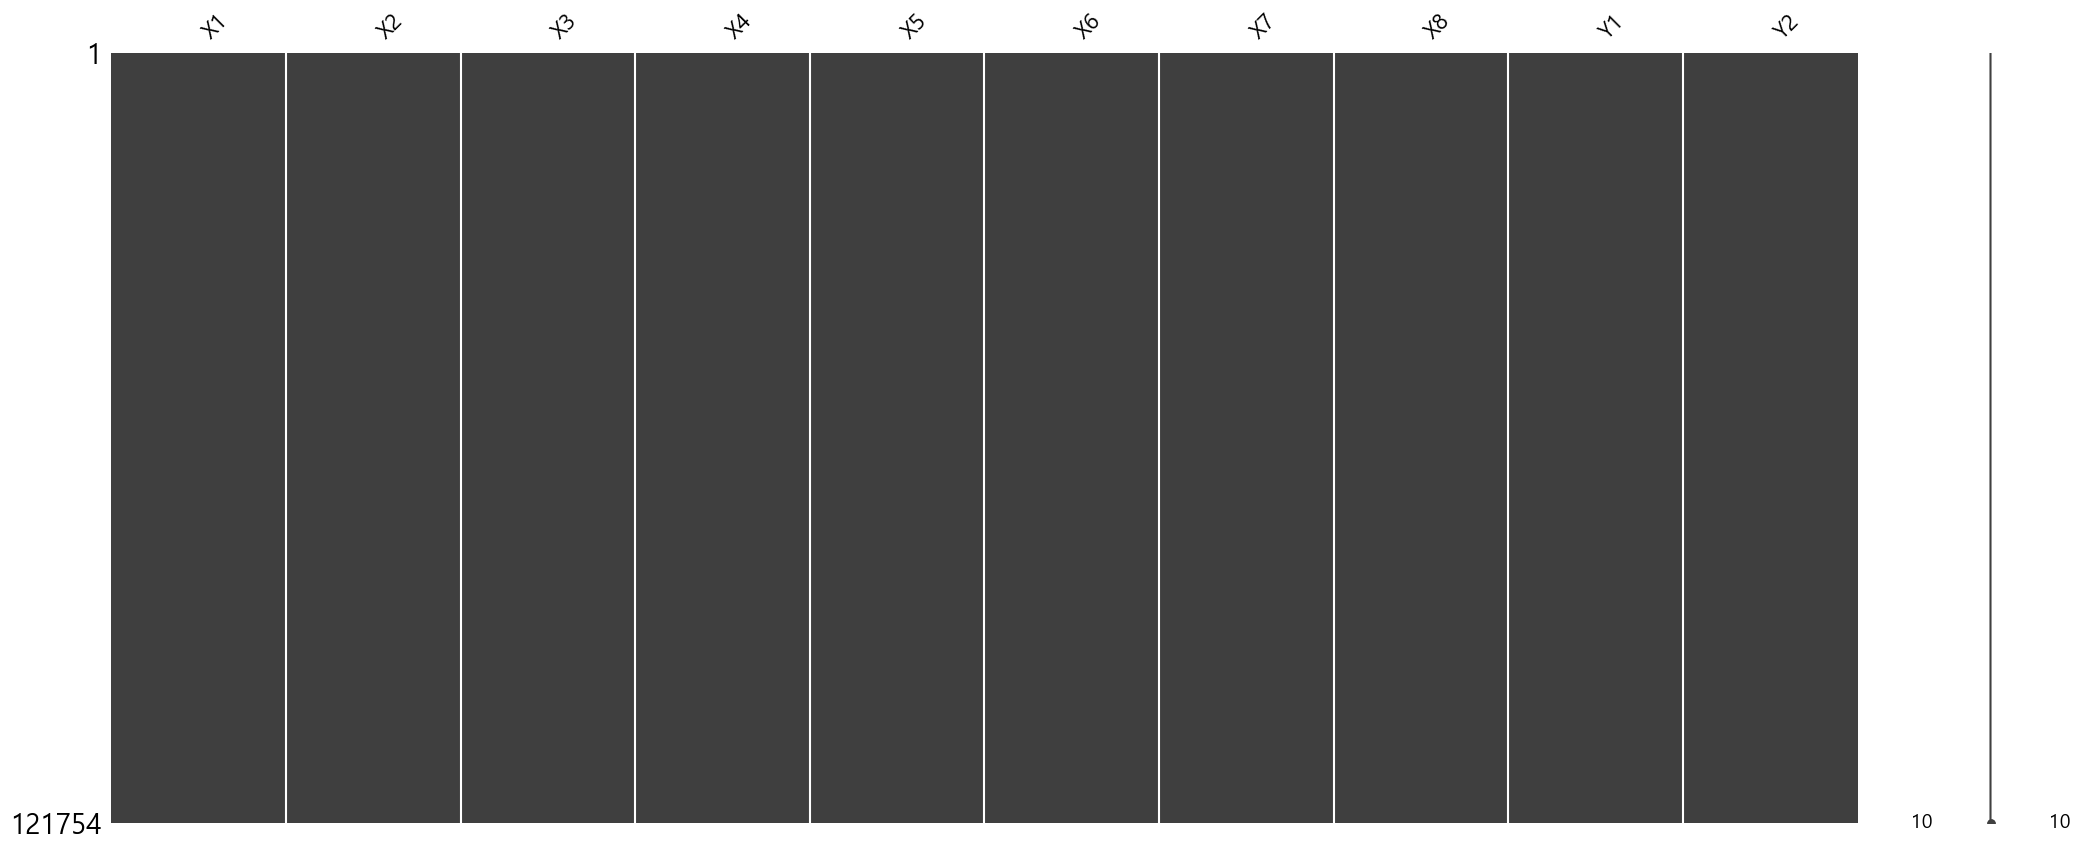

In [10]:
ms.matrix(train)
plt.show()

In [11]:
np.sort(train['X5'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78])

In [12]:
np.sort(train['X8'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

## EDA

<Axes: >

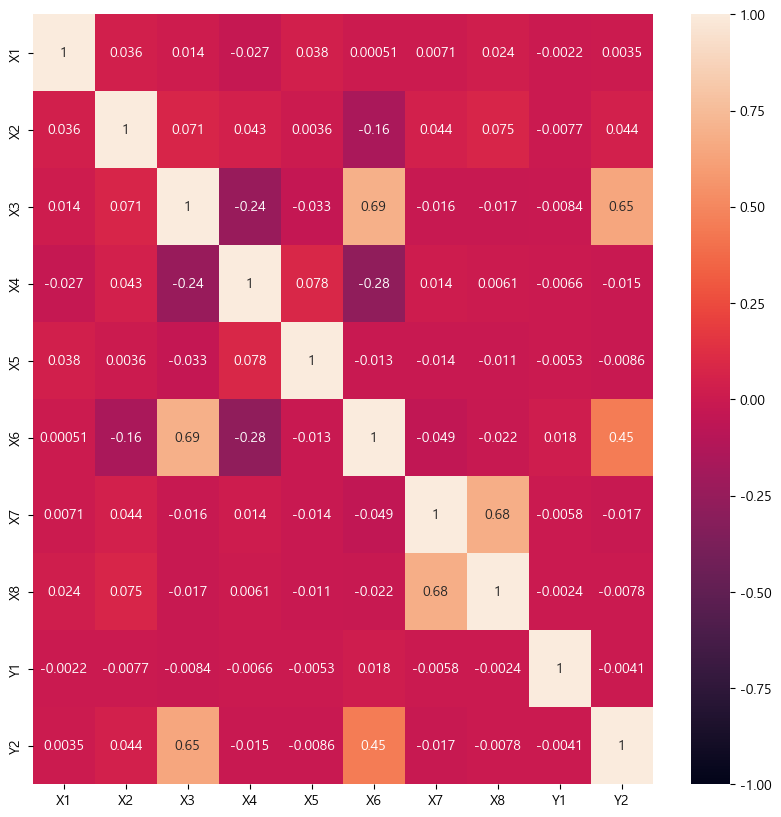

In [13]:
plt.figure(figsize = (10, 10))
sns.heatmap(train.corr(), vmax = 1, vmin = -1, annot = True)

In [14]:
# sns.pairplot(train)

<Figure size 1500x500 with 0 Axes>

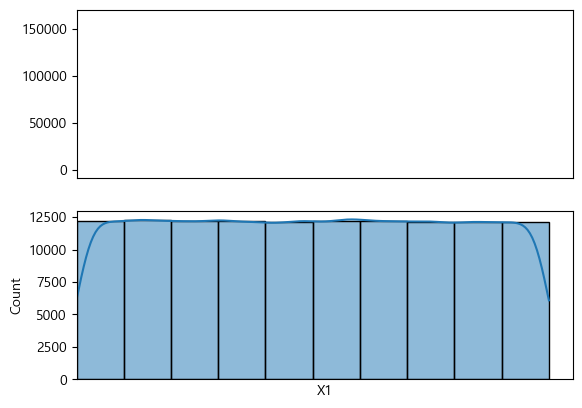

<Figure size 1500x500 with 0 Axes>

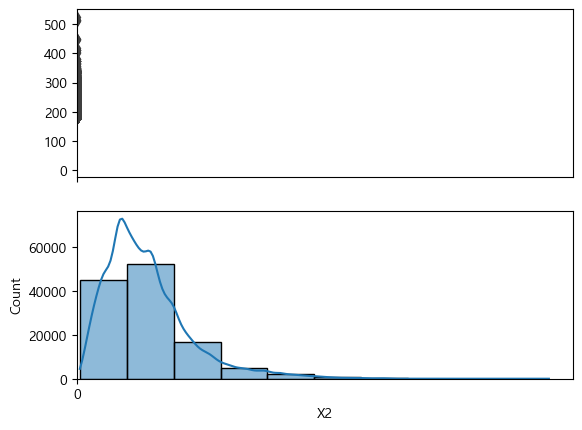

<Figure size 1500x500 with 0 Axes>

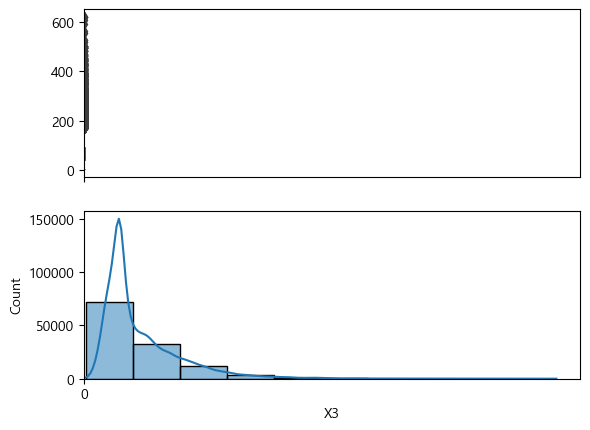

<Figure size 1500x500 with 0 Axes>

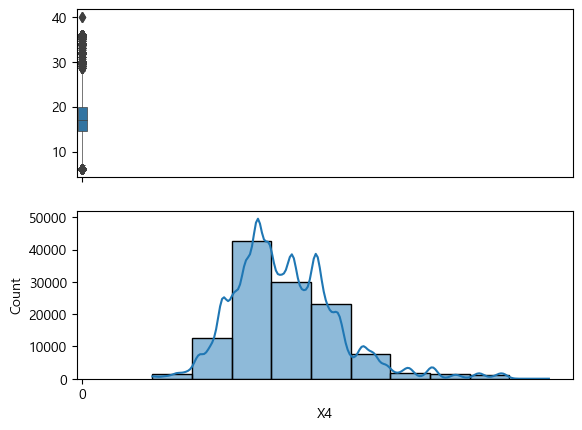

<Figure size 1500x500 with 0 Axes>

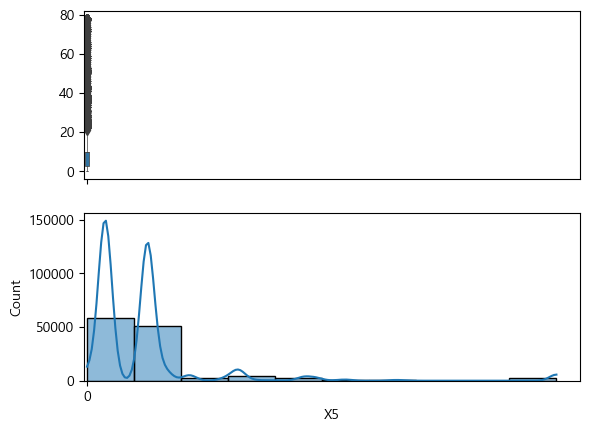

<Figure size 1500x500 with 0 Axes>

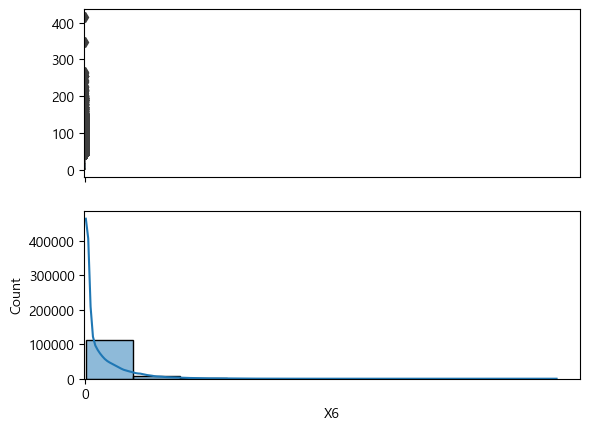

<Figure size 1500x500 with 0 Axes>

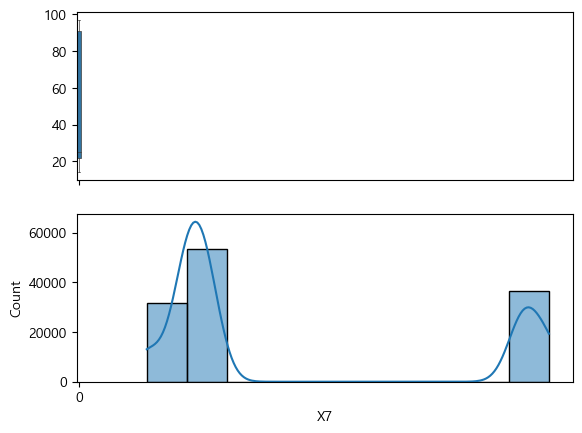

<Figure size 1500x500 with 0 Axes>

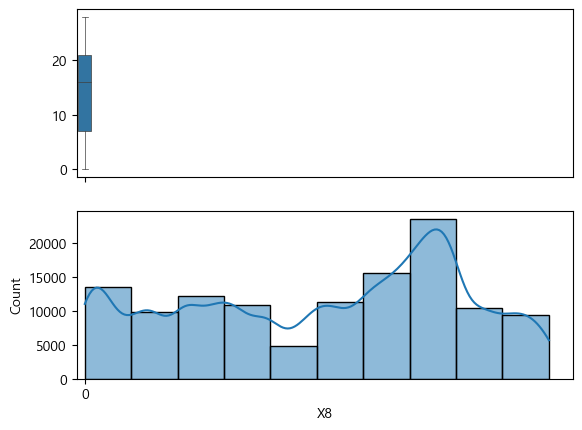

<Figure size 1500x500 with 0 Axes>

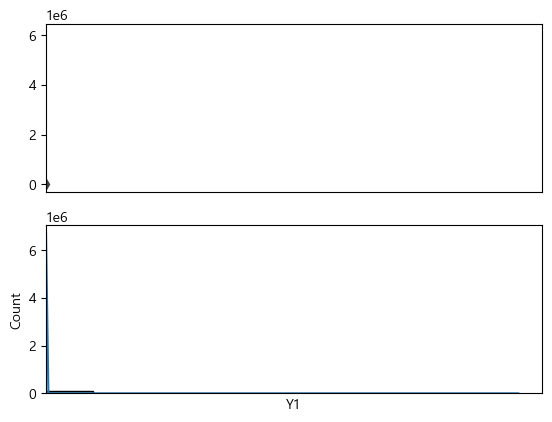

<Figure size 1500x500 with 0 Axes>

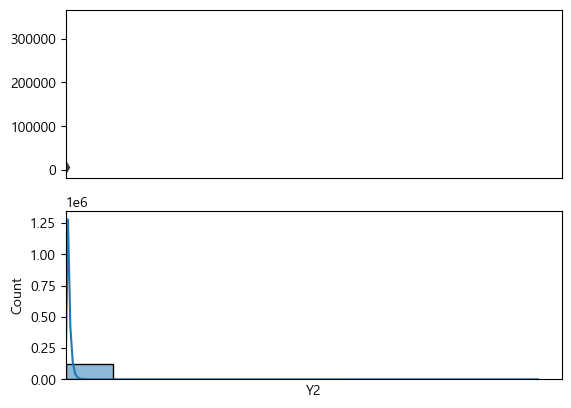

In [15]:
features = train.columns
numeric_features = train.select_dtypes('number').columns
categorical_features = train.select_dtypes('object').columns
for i in numeric_features:
  plt.figure(figsize = (15, 5))
  plt.tight_layout()
  f, (ax_box, ax_hist) = plt.subplots(2, sharex = True)
  sns.boxplot(train[i], ax = ax_box, linewidth = 0.5)
  sns.histplot(train[i], ax = ax_hist, bins = 10, kde = True)

numeric cols : 10
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2'], dtype='object')


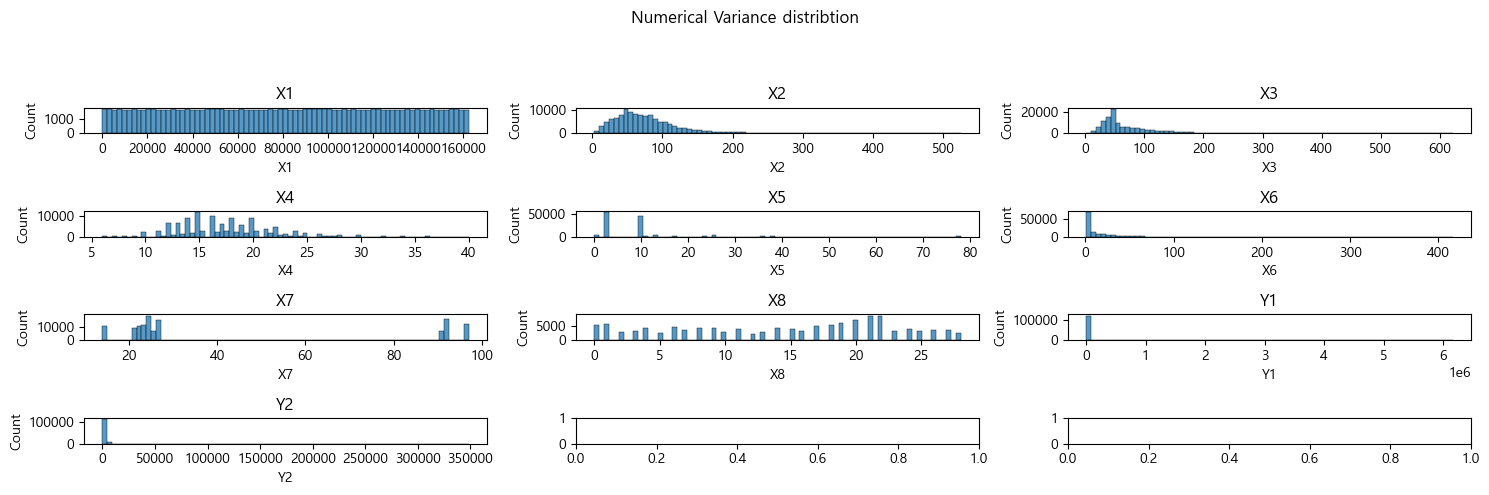

In [16]:
cols_numeric = train.describe().columns

print(f'numeric cols : {len(cols_numeric)}')
print(f'{cols_numeric}')

fig, ax = plt.subplots(4, 3, figsize=(15, 5))

for i in range(len(cols_numeric)):

    x = i // 3    
    y = i % 3
    
    sns.histplot(x=cols_numeric[i], data = train, bins = 75, ax = ax[x,y])
    ax[x, y].set_title(cols_numeric[i])

plt.suptitle('Numerical Variance distribtion\n\n')
plt.tight_layout()
plt.show()

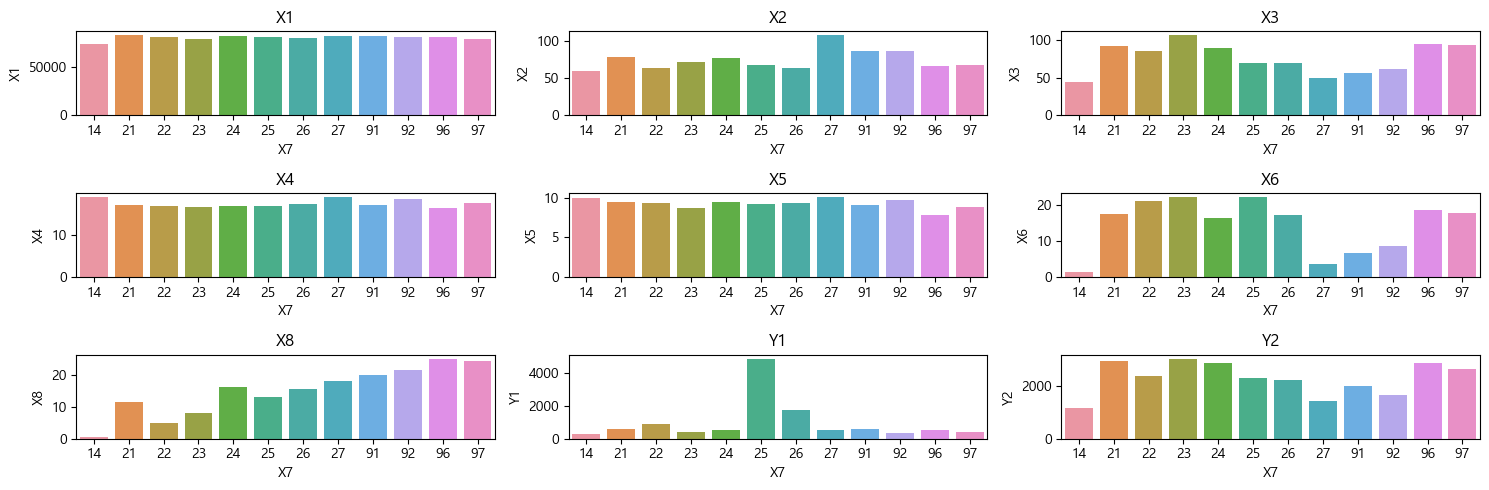

In [17]:
data = train.groupby('X7').mean().reset_index()

fig, axes = plt.subplots(3, 3, figsize=(15, 5))

sns.barplot(x = 'X7', y = 'X1', data = data, ax = axes[0, 0])
axes[0, 0].set_title('X1')

sns.barplot(x = 'X7', y = 'X2', data = data, ax = axes[0, 1])
axes[0, 1].set_title('X2')

sns.barplot(x = 'X7', y = 'X3', data = data, ax = axes[0, 2])
axes[0, 2].set_title('X3')

sns.barplot(x = 'X7', y = 'X4', data = data, ax = axes[1, 0])
axes[1, 0].set_title('X4')

sns.barplot(x = 'X7', y = 'X5', data = data, ax = axes[1, 1])
axes[1, 1].set_title('X5')

sns.barplot(x = 'X7', y = 'X6', data = data, ax = axes[1, 2])
axes[1, 2].set_title('X6')

sns.barplot(x = 'X7', y = 'X8', data= data, ax= axes[2, 0])
axes[2, 0].set_title('X8')

sns.barplot(x = 'X7', y = 'Y1', data = data, ax = axes[2, 1])
axes[2, 1].set_title('Y1')

sns.barplot(x = 'X7', y = 'Y2', data = data, ax = axes[2, 2])
axes[2, 2].set_title('Y2')

plt.tight_layout()
plt.show()

<Axes: xlabel='X2', ylabel='X3'>

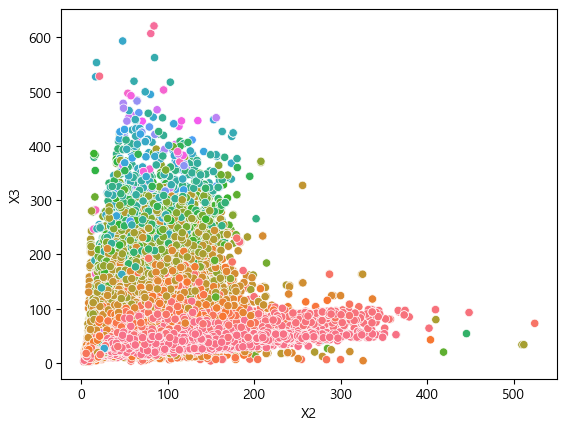

In [18]:
sns.scatterplot(x = train['X2'], y = train['X3'], hue = train['X6'].astype('category'), legend = None)

<Axes: xlabel='X2', ylabel='X3'>

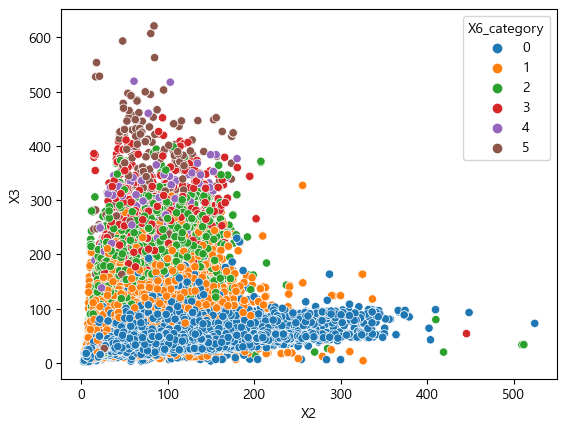

In [19]:
bins = [0, 15, 40, 70, 95, 110, float('inf')]

labels = [0, 1, 2, 3, 4, 5]

train['X6_category'] = pd.cut(train['X6'], bins=bins, labels=labels, include_lowest=True)
test['X6_category'] = pd.cut(test['X6'], bins=bins, labels=labels, include_lowest=True)

train.drop(columns=['X6'], inplace=True)
test.drop(columns=['X6'], inplace=True)

sns.scatterplot(x=train['X2'], y=train['X3'], hue=train['X6_category'].astype('category'))

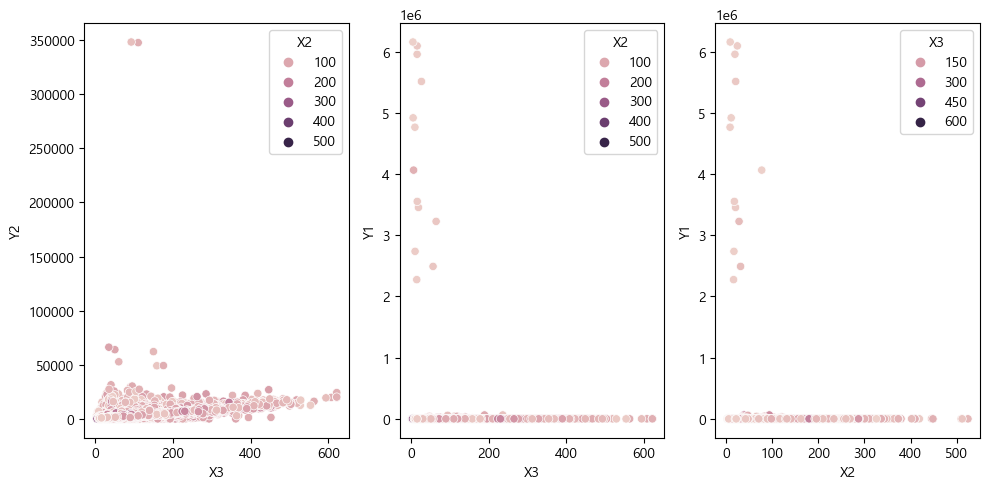

In [20]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'X3', y = 'Y2', hue = 'X2', data = train)

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'X3', y = 'Y1', hue = 'X2', data = train)

plt.subplot(1, 3, 3)
sns.scatterplot(x = 'X2', y = 'Y1', hue = 'X3', data = train)

plt.tight_layout()
plt.show()

In [21]:
train = train[(train['Y1'] > 150) & (train['Y1'] <= 67000) & (train['Y2'] > 150) & (train['Y2'] <= 67000)]

In [22]:
# def remove_outliers(df, col_name):
#     uppper_bound = df[col_name].mean() + 6 * df[col_name].std()
#     lower_bound = df[col_name].mean() - 6 * df[col_name].std()

#     print(f"평균: {df[col_name].mean()}, 표준편차: {df[col_name].std()}")

#     return df[(df[col_name] < uppper_bound) & (df[col_name] > lower_bound)]

# columns_to_process = ['X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2']

# for col in columns_to_process:
#     train = remove_outliers(train, col)

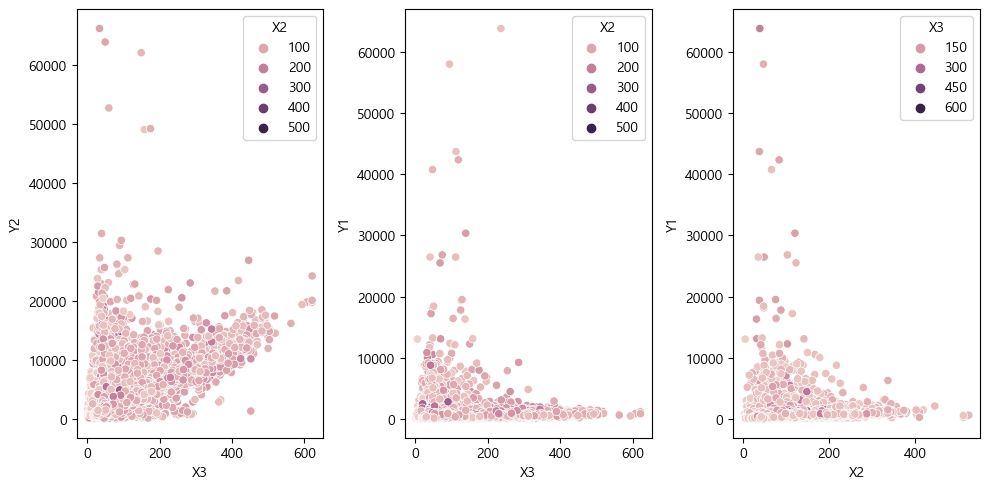

In [23]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'X3', y = 'Y2', hue = 'X2', data = train)

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'X3', y = 'Y1', hue = 'X2', data = train)

plt.subplot(1, 3, 3)
sns.scatterplot(x = 'X2', y = 'Y1', hue = 'X3', data = train)

plt.tight_layout()
plt.show()

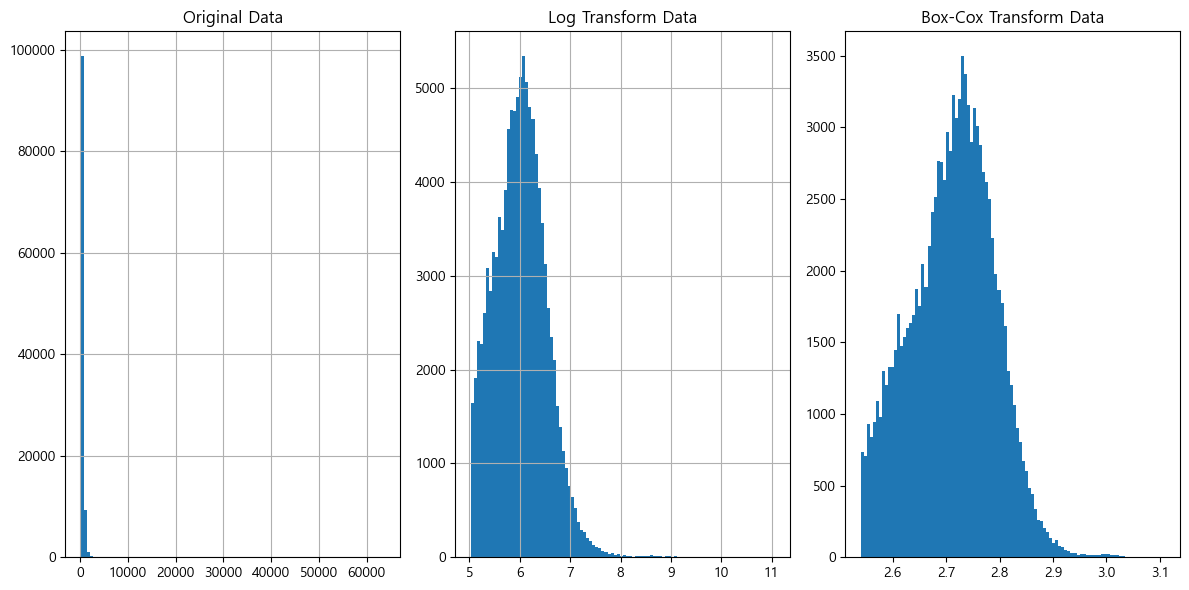

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
train['Y1'].hist(bins=100)
plt.title('Original Data')

plt.subplot(1, 3, 2)
np.log1p(train['Y1']).hist(bins=100)
plt.title('Log Transform Data')

plt.subplot(1, 3, 3)
transformed_data, _ = stats.boxcox(train['Y1'] + 1)
plt.hist(transformed_data, bins=100)
plt.title('Box-Cox Transform Data')

plt.tight_layout()
plt.show()

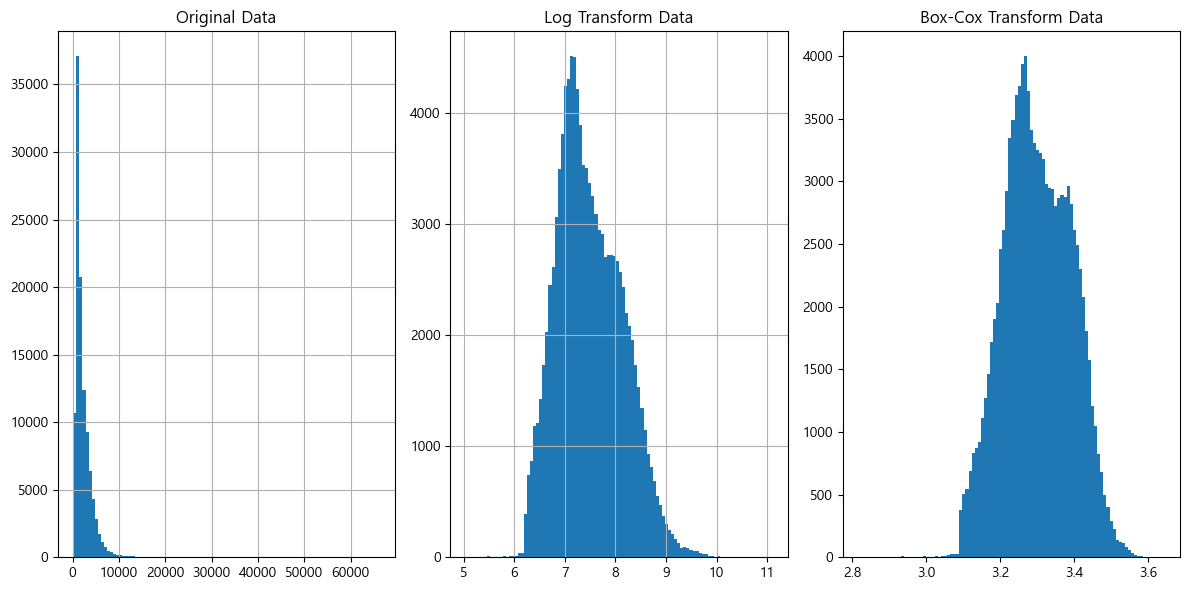

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
train['Y2'].hist(bins=100)
plt.title('Original Data')

plt.subplot(1, 3, 2)
np.log1p(train['Y2']).hist(bins=100)
plt.title('Log Transform Data')

plt.subplot(1, 3, 3)
transformed_data, _ = stats.boxcox(train['Y2'] + 1)
plt.hist(transformed_data, bins=100)
plt.title('Box-Cox Transform Data')

plt.tight_layout()
plt.show()

In [26]:
train_data1 = train[['X1', 'X2', 'X3', 'X4', 'X5', 'X6_category', 'X7', 'X8']]

train_y1 = np.log1p(train['Y1'])
train_y2 = np.log1p(train['Y2'])

<Axes: >

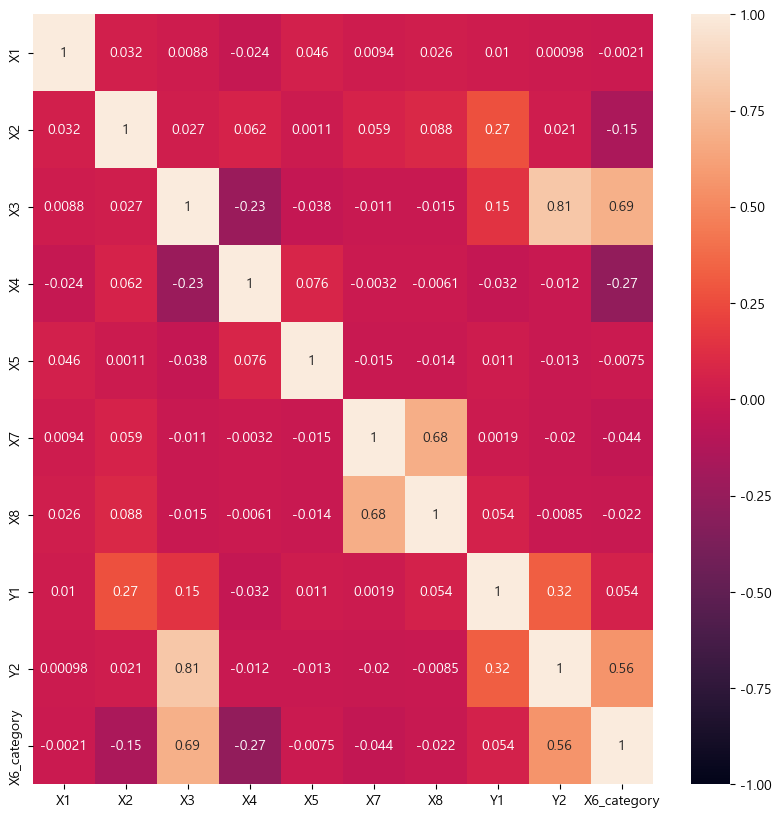

In [27]:
plt.figure(figsize = (10, 10))
sns.heatmap(train.corr(), vmax = 1, vmin = -1, annot = True)

In [28]:
# def train_and_evaluate(model, model_name, X_train, y_train):
#     print(f'Model Tune for {model_name}.')
#     model.fit(X_train, y_train)
    
#     feature_importances = model.feature_importances_
#     sorted_idx = feature_importances.argsort()

#     plt.figure(figsize=(10, len(X_train.columns)))
#     plt.title(f"Feature Importances ({model_name})")
#     plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
#     plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
#     plt.xlabel('Importance')
#     plt.show()
    
#     return model, feature_importances

# X_train = train.drop(columns = ['Y1', 'Y2'])
# Y_train = train[['Y1', 'Y2']]

# # Model Tune for XGB
# xgb_model, xgb_feature_importances = train_and_evaluate(xgb.XGBRegressor(), 'XGB', X_train, Y_train)

In [29]:
numeric_cols = ['X1', 'X2', 'X3', 'X4', 'X7']

scaler = MinMaxScaler()

train_data1[numeric_cols] = scaler.fit_transform(train_data1[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

C:\Users\dlwks\AppData\Local\Temp\ipykernel_6700\1943182327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1[numeric_cols] = scaler.fit_transform(train_data1[numeric_cols])


In [30]:
xgb_y1 = xgb.XGBRegressor(eval_metric='mae',
                          enable_categorical=True 
                          )

X_train_reduced = train_data1.reset_index(drop=True)
y_train = train_y1.reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    xgb_y1.fit(X_t, y_t, eval_set=[(X_val, y_val)], verbose=50)

    val_pred = xgb_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[train_data1.columns]

    xgb_pred = xgb_y1.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-mae:0.33553
[50]	validation_0-mae:0.17829
[99]	validation_0-mae:0.17562


Processing folds:  20%|██        | 1/5 [00:00<00:01,  2.41it/s]

[0]	validation_0-mae:0.33317
[50]	validation_0-mae:0.17673
[99]	validation_0-mae:0.17358


Processing folds:  40%|████      | 2/5 [00:00<00:01,  2.64it/s]

[0]	validation_0-mae:0.33241
[50]	validation_0-mae:0.17139
[99]	validation_0-mae:0.16834


Processing folds:  60%|██████    | 3/5 [00:01<00:00,  2.73it/s]

[0]	validation_0-mae:0.33467
[50]	validation_0-mae:0.17495
[99]	validation_0-mae:0.17172


Processing folds:  80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

[0]	validation_0-mae:0.33539
[50]	validation_0-mae:0.17544
[99]	validation_0-mae:0.17237


Processing folds: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

Validation : MAE scores for each fold: [0.1756215994188869, 0.1735822618633223, 0.16834447013678341, 0.17171862281558758, 0.17237055648426855]
Validation : MAE: 0.17232750214376974


In [31]:
xgb_y2 = xgb.XGBRegressor(eval_metric='mae',
                          enable_categorical=True 
                          )

X_train_reduced = train_data1.reset_index(drop=True)
y_train = train_y2.reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    xgb_y2.fit(X_t, y_t, eval_set=[(X_val, y_val)], verbose=50)

    val_pred = xgb_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    xgb_pred = xgb_y2.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-mae:0.39593
[50]	validation_0-mae:0.11021
[99]	validation_0-mae:0.10952


Processing folds:  20%|██        | 1/5 [00:00<00:01,  2.66it/s]

[0]	validation_0-mae:0.39695
[50]	validation_0-mae:0.10702
[99]	validation_0-mae:0.10617


Processing folds:  40%|████      | 2/5 [00:00<00:01,  2.76it/s]

[0]	validation_0-mae:0.39713
[50]	validation_0-mae:0.10803
[99]	validation_0-mae:0.10717


Processing folds:  60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

[0]	validation_0-mae:0.39691
[50]	validation_0-mae:0.10844
[99]	validation_0-mae:0.10817


Processing folds:  80%|████████  | 4/5 [00:01<00:00,  2.83it/s]

[0]	validation_0-mae:0.39911
[50]	validation_0-mae:0.10708
[99]	validation_0-mae:0.10633


Processing folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

Validation : MAE scores for each fold: [0.10952289814202018, 0.10616912437117637, 0.107172060468076, 0.10816510566284779, 0.10633060959199968]
Validation : MAE: 0.107471959647224


In [32]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [33]:
final_predictions = (np.exp(final_predictions_y1) - 1) + (np.exp(final_predictions_y2) - 1)


submit.iloc[:, 1] = final_predictions

submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1003_5.csv', index=False)

In [34]:
submit

,Id,Predicted
0,0,3010.079102
1,1,1822.699463
2,2,3205.632324
3,3,4637.593750
4,4,1850.315063
...,...,...
40566,40566,984.164429
40567,40567,1201.367432
40568,40568,2082.357422
40569,40569,1124.376099
